# Exploring the Data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
closing_price = pd.read_pickle("./data/stocks/closing_prices.pkl")
volumes = pd.read_pickle("./data/stocks/volumes.pkl")
HMLs = pd.read_pickle("./data/stocks/HMLs.pkl")

In [3]:
closing_price.head()

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31 00:00:00-04:00,119.091064,54.044529,96.999535,140.715378,279.459991,94.968796,318.500000,236.614792,25.615273,63.578457,...,215.037827,578.000854,63.586994,63.053558,101.175644,116.083115,283.220001,112.488220,49.660881,149.774765
2022-11-01 00:00:00-04:00,118.627167,53.866943,97.362274,141.205582,277.067993,95.507393,316.019989,238.513962,25.791525,65.238472,...,217.984344,586.260132,67.527603,63.818604,104.247551,115.984947,238.300003,110.989700,49.345360,151.701843
2022-11-02 00:00:00-04:00,116.317108,52.979031,96.117180,138.908371,268.189056,93.813271,301.220001,232.444397,25.292147,65.121300,...,216.929901,577.634888,66.801170,63.247234,102.993103,115.219238,236.029999,106.871262,47.318386,146.377563
2022-11-03 00:00:00-04:00,116.307640,53.640030,94.558372,138.812241,252.862579,94.283310,285.929993,231.132614,25.644648,64.418236,...,214.791443,587.941711,66.154366,63.092289,105.857597,117.310219,227.320007,104.618507,46.008495,130.265701
2022-11-04 00:00:00-04:00,118.191650,55.228413,96.146599,139.638870,257.075592,93.215919,285.750000,231.876617,25.909025,65.599770,...,217.994202,587.189941,70.463142,63.479664,105.897102,119.548424,230.559998,104.052841,47.576530,132.778839


<AxesSubplot:xlabel='Date'>

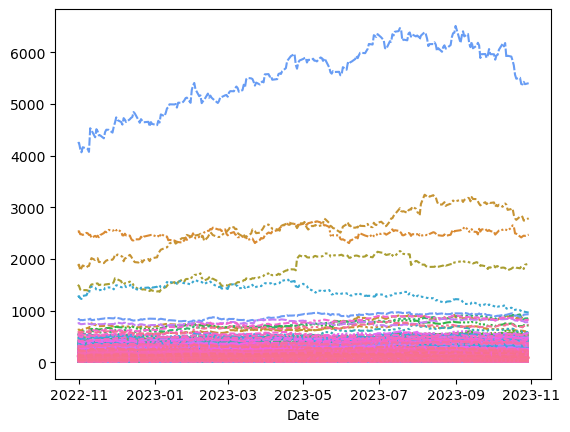

In [4]:
sns.lineplot(data = closing_price, legend = None)

In [5]:
closing_price.idxmax(axis=1)[0] # lol what even is this stock?

'NVR'

In [6]:
# Compare this to the stock price of, say, Microsoft
closing_price["MSFT"][0]

229.9088897705078

As we can see, the price distribution of stocks is not uniform, so when clustering them like this, we will not get things that are informative to identify their motions. Thus, we choose a way to normalize:
- L^2 normalization: divides each column by its L^2 norm
- Percent normalization: instead of keeping track of the change in price, keep track of the *percent change in price*
- Binary normalization: sign(percent normalization)

<AxesSubplot:xlabel='Date'>

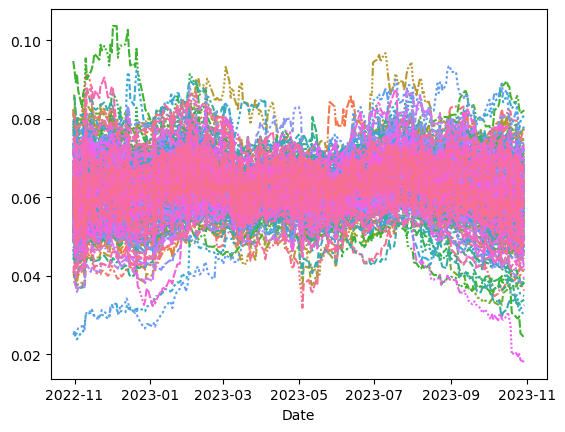

In [7]:
closing_price_l2 = closing_price / closing_price.apply(lambda x: np.linalg.norm(x))
sns.lineplot(data = closing_price_l2, legend = None)

<AxesSubplot:xlabel='Date'>

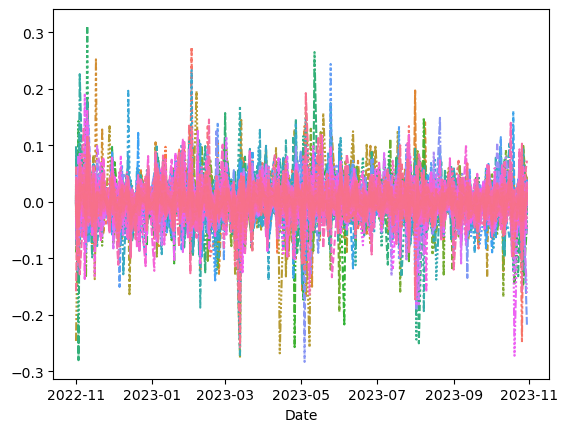

In [8]:
closing_price_percent = closing_price.pct_change()[1:]
sns.lineplot(data = closing_price_percent, legend = None)

<AxesSubplot:xlabel='Date'>

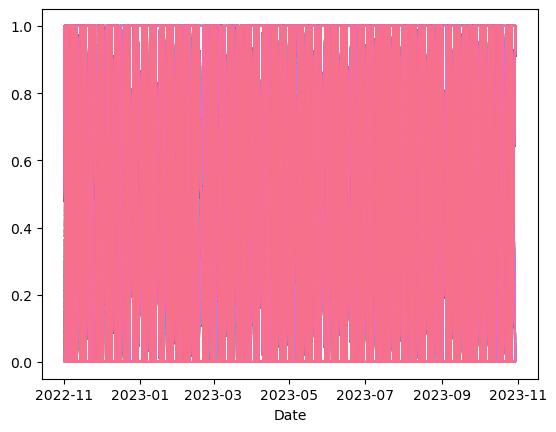

In [9]:
closing_price_updn = 1 * (closing_price_percent > 0)
# This plot is very silly
sns.lineplot(data = closing_price_updn, legend = None)

For now, we will work with the L^2 normalization.

# Duplicate Stocks

<AxesSubplot:xlabel='Date'>

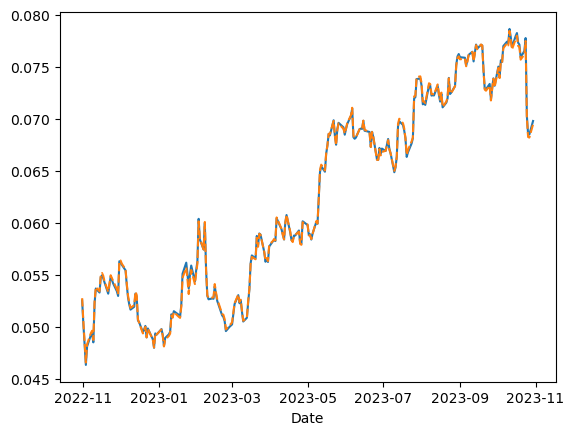

In [10]:
sns.lineplot(data = closing_price_l2[["GOOG", "GOOGL"]], legend = None)

It turns out that some stocks are listed twice in the dataset, such as GOOG and GOOGL. The main difference between the GOOG and GOOGL stock ticker symbols is that GOOG shares have no voting rights, while GOOGL shares do.

We can find all such pairs, and look at the correlation matrix of the closing price, and try to tease out when stocks are the same based on their correlation.

In [11]:
# Delete GOOG
closing_price_l2.drop("GOOG", axis = 1, inplace = True)

In [12]:
tickers_clean = closing_price_l2.columns

In [13]:
corr_l2 = np.tril(closing_price_l2.corr().values, -1)
high_corrs_l2 = np.where((corr_l2 > 0.95).astype(int) == 1)
high_corrs_l2 = list(zip(high_corrs_l2[0], high_corrs_l2[1]))

In [14]:
for i, j in high_corrs_l2:
    tick1 = tickers_clean[i]
    tick2 = tickers_clean[j]
    print(f"Correlation between {tick1} and {tick2} is: {corr_l2[i][j]}")

Correlation between AMZN and GOOGL is: 0.9548953660898524
Correlation between AMCR and AES is: 0.9598477043395548
Correlation between AMCR and A is: 0.9558158135411159
Correlation between AVGO and ADBE is: 0.9610569216983931
Correlation between AVGO and AMAT is: 0.9613603831061627
Correlation between BRO and AJG is: 0.9616503518501723
Correlation between COR and CAH is: 0.9689571710193865
Correlation between CFG and ARE is: 0.9529403032478778
Correlation between CMA and SCHW is: 0.9674014660816158
Correlation between CMA and CFG is: 0.97152717587217
Correlation between CAG and CPB is: 0.9548141699803889
Correlation between CPRT and CDNS is: 0.9632536849019021
Correlation between CCI and AMCR is: 0.9530875157916533
Correlation between CCI and AMT is: 0.9541232250206739
Correlation between LLY and AJG is: 0.9530480908619328
Correlation between EL and CCI is: 0.9530722637286151
Correlation between ES and AES is: 0.9522240608616479
Correlation between ES and AEP is: 0.9771295836276148
Corr

It is interesting to note that some usual suspects arehighly correlated, like GOOG (Google) and AMZN (Amazon). But going further down the list, we see lesser-known companies, like ZION and KEY, which are both small regional banks (in Utah and Idaho respectively)

<AxesSubplot:xlabel='Date'>

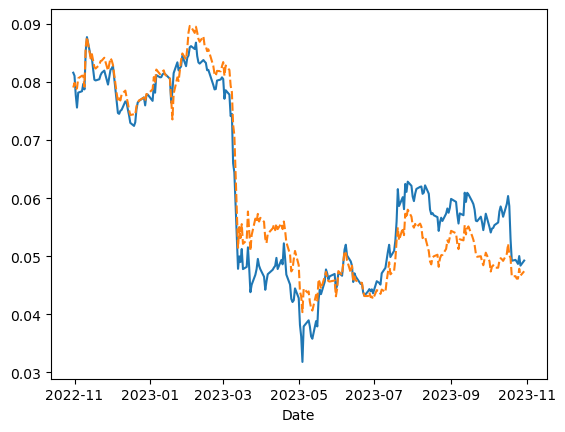

In [15]:
ax, fig = plt.subplots()
sns.lineplot(data = closing_price_l2[["ZION", "KEY"]], legend = None)

# Smoothed Data

We may also be interested in some averages to hopefully see some trends. For readability, only small samples of the data are plotted.

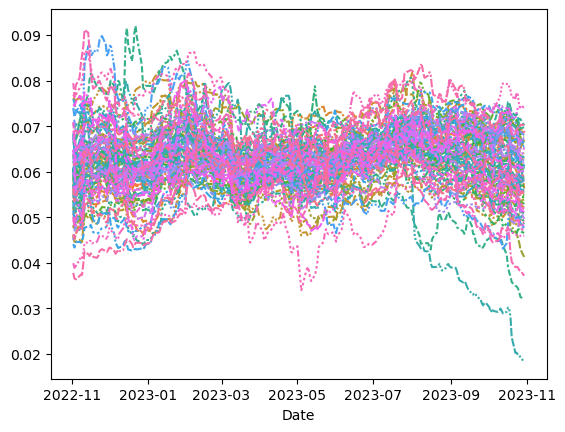

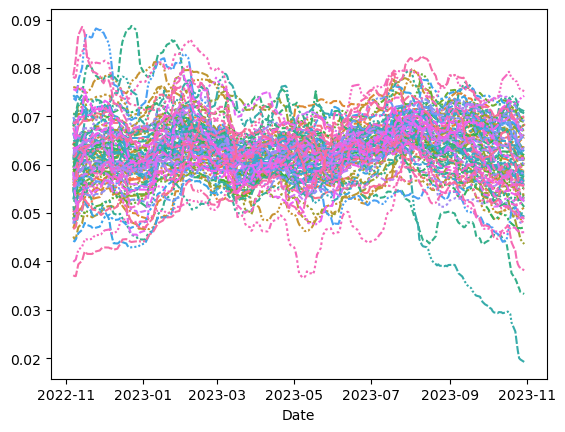

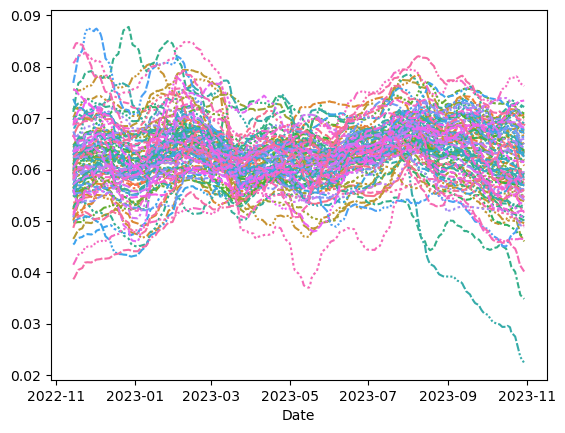

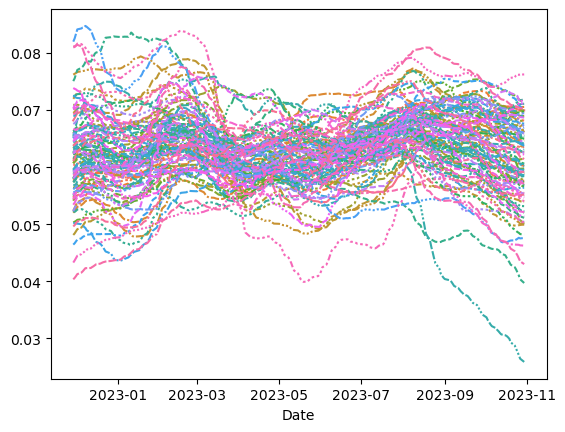

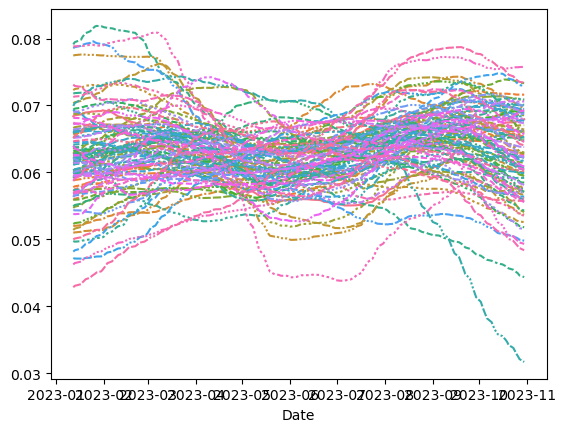

In [16]:
#fig, axs = plt.subplots(5, 1)
for i, width in zip(range(5), [2, 5, 10, 20, 50]):
    smoothed_data = closing_price_l2.rolling(window=width,center=False).mean()[width:]
    fig, ax = plt.subplots()
    sns.lineplot(data = smoothed_data.sample(100, axis = 1, random_state = 42), legend = None)

# Examining Correlations

It's impractical to look at all of the correlations in a 500x500 matrix. Nevertheless, we can still try to look at the *collection* of correlations to see if there are any equities that look like they *do* move together. We will plot some histograms of correlations

<AxesSubplot:ylabel='Count'>

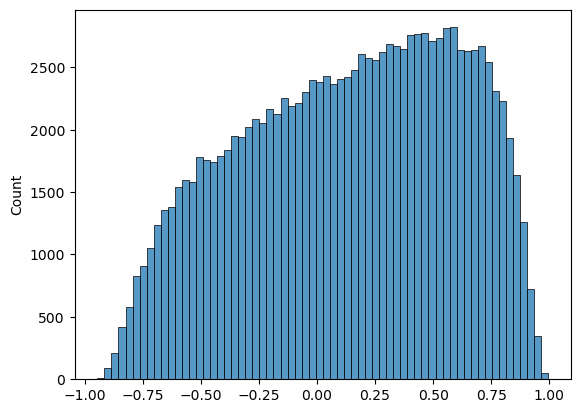

In [17]:
corr_l2 = np.tril(closing_price_l2.corr().values, -1)
corrs_l2 = corr_l2[np.nonzero(corr_l2)]
sns.histplot(corrs_l2)

As a baseline model, we can cluster the equities by industry, and see if the correlations have anything to do with the industry of the equity.

In [18]:
industries = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
industries = industries[0][["Symbol", "GICS Sector"]].set_index("Symbol")["GICS Sector"].to_dict()
industries_cleaned = {tick : industries[tick] for tick in tickers_clean}

In [19]:
industry_corr = {}
for i in range(len(tickers_clean)):
    for j in range(i):
        tick1 = tickers_clean[i]
        tick2 = tickers_clean[j]
        industry_corr[tick1 + '+' + tick2] = [corr_l2[i][j], 
                                           1*(industries_cleaned[tick1] == industries_cleaned[tick2])]

In [20]:
same_industry_corr_df = pd.DataFrame.from_dict(industry_corr, 
                                               orient='index', 
                                               columns = ["Corr", "Same Industry?"])
same_industry_corr_df["Same Industry?"] = same_industry_corr_df["Same Industry?"].replace({1 : "same industry", 0 : "different industry"})

<AxesSubplot:xlabel='Corr', ylabel='Count'>

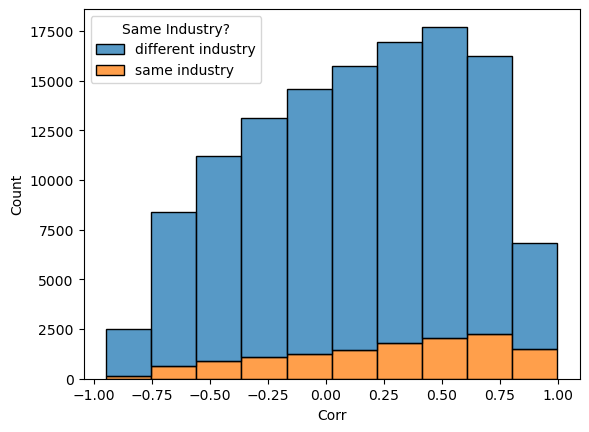

In [21]:
sns.histplot(data=same_industry_corr_df,
             bins = 10,
             x="Corr", 
             hue="Same Industry?", 
             hue_order = ["different industry", "same industry"],
             multiple="stack")

This is excellent news! This means that not all of the correlation is due to equities being in the same industry!